<a href="https://colab.research.google.com/github/omanshuthapliyal/formationControl/blob/master/SupervisoryControlAttack_formation_of_robots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Defining ***Robot Formation*** model.

Adapted from [Hybrid Control of Formation of Robots](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=932546).



In [0]:
from numpy import matmul 
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
from math import sin, cos
import scipy.integrate as integrate

## Plant Objects

In [0]:
def stateProp(xDot, x, t, dt):
  # xDot = dx/dt = constant during dT, x = x(t), dt = Delta T
  dx = xDot*dt
  x += dx
  return x
  
class PLANT:
  def __init__(self):
    self.d = 0.1 # Robot size, perhaps. See Figs. 1 & 2
    self.v = np.zeros([3, 1])
    self.v[0] = 0.5
    self.gamma = np.zeros((3,3))
    self.b = np.zeros_like(self.gamma)
    self.s = np.zeros_like(self.b)
    self.l = np.zeros_like(self.b)
    self.lDot = np.zeros_like(self.b)
    self.psi = np.zeros_like(self.b)
    self.psiDot = np.zeros_like(self.b)
    self.l_des = np.ones_like(self.b) - np.diag([1,1,1])
    self.psi_des = (np.ones_like(self.b) - np.diag([1,1,1]))*np.pi/2
    # Initial conditions given in the beginning of Section 4
    self.x = np.array([0, 1.5, 0.2])
    self.y = np.array([0, 0, 2])
    self.theta = np.array([30, 0, 30])/(np.pi/180)
    self.xDot = np.array([0.5, 0, 0])
    self.yDot = np.array([0, 0, 0])
    self.thetaDot = np.array([0, 0, 0])
    self.w = np.array([0, 0, 0,])
    self.k0 = 1
    self.k1 = 1
    self.k2 = 1
    self.mode = 4 # Autonomous navigation by default
    self.t = 0 # Initializing with zero time
    # Adding sensor ranges
    self.r = 1.2*np.ones_like(self.x)

  def SBijC(self,i,j):
  # Separation Bearing Control (SB[i,j]C)
  # Eqs. 2-5 robot j follows robot i
  # Parameters: Eq. 4
    self.s[i][j] = self.k1*(self.l_des[i][j] - self.l[i][j])
    self.b[i][j] = self.k2*(psi_des[i][j] - self.psi[i][j])
    self.gamma[i][j] = self.theta[i] - self.theta[j] + self.psi[i][j]
    # Control velocities: Eqs. 2, 3
    self.v[j] = self.s[i][j]*cos(self.gamma[i][j]) \
    - self.l[i][j] * sin(self.gamma[i][j]) * (self.b[i][j] + self.w[i] ) \
    + self.v[i]*sin(self.theta[i] - self.theta[j])

    self.w[j] = (self.s[i][j]*sin(self.gamma[i][j]) \
                - self.l[i][j] * cos(self.gamma[i][j]) * (self.b[i][j] + self.w[i] ) \
                + self.v[i]*sin(self.theta[i] - self.theta[j])) / self.d
    # Updating relative states: Eq. 5
    self.lDot[i][j] = self.k1*(self.l_des[i][j] - self.l[i][j])
    self.psiDot[i][j] = self.k2*(self.psi_des[i][j] - self.psi[i][j])
    self.thetaDot[j] = self.w[j]

  def SSC(self,i,j,k):
  # Separation Separation Control (S[i,k]S[j,k]C)
  # Eqs. 6-8 where robot k follows i and j
  # Parameters: Eq. 4
    self.s[i][j] = self.k1*(self.l_des[i][j] - self.l[i][j])
    self.b[i][j] = self.k2*(self.psi_des[i][j] - self.psi[i][j])
    self.gamma[i][j] = self.theta[i] - self.theta[j] + self.psi[i][j]
    # Control Velocities
    self.v[k] = (self.s[i][k] * sin(self.gamma[j][k]) \
                  - self.s[j][k] * sin(self.gamma[i][k]) \
                  + self.v[i] * cos(self.psi[i][k]) * sin(self.gamma[j][k]) \
                  - self.v[j] * cos(self.psi[j][k]) * sin(self.gamma[i][k]) )\
                  / sin(self.gamma[j][k] - self.gamma[i][k])
    self.w[k] = (- self.s[i][k] * cos(self.gamma[j][k]) \
                + self.s[j][k] * cos(self.gamma[i][k])  \
                - self.v[i] * cos(self.psi[i][k]) * cos(self.gamma[j][k]) \
                - self.v[j] * cos(self.psi[j][k]) * cos(self.gamma[i][k]) ) \
                / (self.d* sin(self.gamma[j][k] - self.gamma[i][k]) )
    # Updating relative states: Eq. 5
    self.lDot[i][k] = self.k1*(self.l_des[i][k] - self.l[i][k])
    self.lDot[j][k] = self.k1*(self.l_des[j][k] - self.l[j][k])
    self.thetaDot[k] = self.w[k]

  def autoNavig(self, i):
  # AutoNavig Controller
    self.v[i] = 0
    self.w[i] = 0.1*sin(0.2*self.t)
    
  def propagate(self, supervObj, i, dt):
    # ID = 1, 2, 3 are robot numbers. We are interested in Robot 3
    if i == 1 or i == 2:
      self.autoNavig(i)
    else:
      mode = supervObj.switch(self)
      if mode == 1: 
        self.SBijC(1,3)    # Robot 3 follows Robot 1
      elif mode == 2: 
        self.SBijC(2,3)    # Robot 3 follows Robot 2
      elif mode == 3: 
        self.SSC(1,2,i)   # Robot 3 follows Robot 1 & 2 
      elif mode == 4: # Autonomous Navigation for Robot 3
        self.autoNavig(i)
    # Getting state derivatives from control input, Eq. 1
    self.xDot[i] = self.v[i] * cos(self.theta[i])
    self.yDot[i] = self.v[i] * sin(self.theta[i])
    self.thetaDot[i] = self.w[i]
    # Propagating state based on updated control input
    self.x[i] = stateProp(self.xDot[i], self.x[i], self.t, dt)
    self.y[i] = stateProp(self.yDot[i], self.y[i], self.t, dt)
    self.theta[i] = stateProp(self.thetaDot[i], self.theta[i], self.t, dt)
    self.t += dt

## Supervisor Model

In [0]:
 class supervisor:
    def switch(self, Plant):
    # Supervisory Logic for Robot 3, where it can detect robots 1 & 2
    # based on Section 3.1
      b1 = (Plant.
            l[0][2] < Plant.l[1][2]) and\
      (Plant.l[1][2] > Plant.r[0]) and\
      (Plant.l[0][2] < Plant.r[1]) 
      b2 = (Plant.l[0][2] > Plant.l[1][2]) and\
      (Plant.l[0][2] > Plant.r[0]) and\
      (Plant.l[1][2] < Plant.r[1]) 
      b3 = (Plant.l[0][2] < Plant.r[0]) and\
      (Plant.l[1][2] < Plant.r[0])
      b4 = (Plant.l[0][2] > Plant.r[1]) and\
      (Plant.l[1][2] > Plant.r[1])
      if b1 == True: mode = 1
      elif b2 == True: mode = 2
      elif b3 == True: mode = 3
      elif b4 == True: mode = 4
      return mode

## Propagate plant to simulate supervisor
Not used in training, only to visualize plant behaviour

In [0]:
# Initial parameters for running plant 
ROBOTS = [PLANT(), PLANT(), PLANT()]
tSim = 10*np.pi
SUP = supervisor()
dT = 0.1 # seconds
tHISTORY = np.zeros((int(tSim/dT)+1,1))
xHISTORY = np.zeros((tHISTORY.size,3))
yHISTORY = np.zeros_like(xHISTORY)

In [201]:
ROBOTS[2].psi_des

array([[0.        , 1.57079633, 1.57079633],
       [1.57079633, 0.        , 1.57079633],
       [1.57079633, 1.57079633, 0.        ]])

In [205]:
xHISTORY[0][0] = 0
xHISTORY[0][1] = 1.5
xHISTORY[0][2] = 0.2
xHISTORY[0][0] = 0
xHISTORY[0][1] = 0
xHISTORY[0][2] = 2
for t in range(tHISTORY.size):
  for i in range(3):
    print(i, ROBOTS[i])
    ROBOTS[i].propagate(SUP, i, dT)
    xHISTORY[t+1][i] = ROBOTS[i].x[i]
    yHISTORY[t+1][i] = ROBOTS[i].y[i]

for i in range(3):
    ax = plt.plot(xHISTORY[:][i], yHISTORY[:][i])


0 <__main__.PLANT object at 0x7ffae8575048>
[nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


ValueError: ignored

# Building Statistical model of Supervisory logic

## Making Queries to the Supervisor object

In [0]:
#Import necessary packages
import numpy as np
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.layers import Dense, Dropout
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras import backend as K

In [0]:
# Making Queries to the Supervisor
nDim = 4
nModes = 2
mean = np.zeros(nDim)
cov = np.eye(4)*100
nQ = 15000
# Collecting data from Queries
data = np.zeros((nQ, nDim))
labels = np.zeros(nQ)
ctr = 0
for i in range(nQ):
  data[i,:] = np.random.multivariate_normal(mean,cov)
  s = SUP.switch(data[i,:])
  if s == 1: 
    ctr+=1
    labels[i] = 1 
k = np.random.choice(nQ)
# Converting labels to one-hot-vectors
labels = keras.utils.np_utils.to_categorical(labels, num_classes=nModes)
# Splitting dataset
data_train = data[0:10000,:]
labels_train = labels[0:10000,:]
data_test = data[10000:,:]
labels_test = labels[10000:,:]

## Defining Neural Network Architecture

In [0]:
def NN_arch():
  model = Sequential()

  # Input Layer: accepts nDim number of inputs
  model.add(Dense(units = nDim, 
                  use_bias = True, 
                  kernel_initializer = "uniform"))
  # Second Layer with 3 units
  model.add(Dense(units = 3,
                  use_bias = True,
                  kernel_initializer = "uniform",
                  activation = "relu"))
  model.add(Dropout(0.30))
  '''
  # Third Layer with 6 units
  model.add(Dense(units = 6,
                  use_bias = True,
                  kernel_initializer = "uniform",
                  activation = "relu"))
  model.add(Dropout(0.30))
  '''
  # Output Layer with 2 units
  model.add(Dense(units = nModes,
                  activation = "sigmoid",
                  kernel_initializer = "uniform"))
  return model

## Training model

### Building Model

In [0]:
supervisorApprox = NN_arch()
supervisorApprox.build((None, nDim))
print(supervisorApprox.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_89 (Dense)             (None, 3)                 15        
_________________________________________________________________
dropout_6 (Dropout)          (None, 3)                 0         
_________________________________________________________________
dense_90 (Dense)             (None, 2)                 8         
Total params: 43
Trainable params: 43
Non-trainable params: 0
_________________________________________________________________
None


### Training model

In [0]:
print(data_train.shape)
supervisorApprox.compile(loss="mean_squared_error", 
                    optimizer = "adam", 
                    metrics = ['accuracy'])
supervisorApprox_metaData = supervisorApprox.fit(
                data_train, labels_train, 
                validation_data = (data_test, labels_test), 
                epochs = 50, 
                batch_size = 100, 
                shuffle = True)
#Print accuracy of model on testing set after training 
scores = supervisorApprox.evaluate(data_test, labels_test)
print("Accuracy: %0.4f%%" %(scores[1]*100) )

(10000, 4)
Train on 10000 samples, validate on 5000 samples
Epoch 1/50
10000/10000 [==============================] - 2s 193us/step - loss: 0.2318 - acc: 0.9668 - val_loss: 0.1985 - val_acc: 0.9764
Epoch 2/50
10000/10000 [==============================] - 0s 18us/step - loss: 0.1608 - acc: 0.9790 - val_loss: 0.1282 - val_acc: 0.9764
Epoch 3/50
10000/10000 [==============================] - 0s 19us/step - loss: 0.1274 - acc: 0.9790 - val_loss: 0.1106 - val_acc: 0.9764
Epoch 4/50
10000/10000 [==============================] - 0s 19us/step - loss: 0.1134 - acc: 0.9790 - val_loss: 0.0994 - val_acc: 0.9764
Epoch 5/50
10000/10000 [==============================] - 0s 21us/step - loss: 0.1037 - acc: 0.9790 - val_loss: 0.0903 - val_acc: 0.9764
Epoch 6/50
10000/10000 [==============================] - 0s 19us/step - loss: 0.0944 - acc: 0.9790 - val_loss: 0.0824 - val_acc: 0.9764
Epoch 7/50
10000/10000 [==============================] - 0s 18us/step - loss: 0.0865 - acc: 0.9790 - val_loss: 0.075

### Model Performance Plots

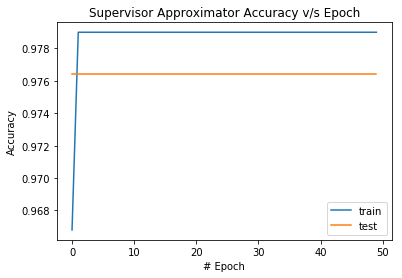

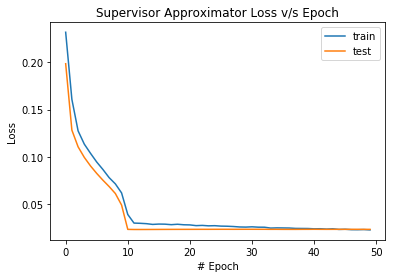

In [0]:
#Plot accuracy vs epoch
plt.plot(supervisorApprox_metaData.history['acc'])
plt.plot(supervisorApprox_metaData.history['val_acc'])
plt.title('Supervisor Approximator Accuracy v/s Epoch')
plt.xlabel('# Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc = 'lower right')
plt.show()

#Plot loss vs epoch
plt.plot(supervisorApprox_metaData.history['loss'])
plt.plot(supervisorApprox_metaData.history['val_loss'])
plt.title('Supervisor Approximator Loss v/s Epoch')
plt.xlabel('# Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

# Performing Attacks

## Gradient Calculation for Statistical model of Supervisory logic

In [0]:
grads = K.gradients(supervisorApprox.output, supervisorApprox.input)
sess = K.get_session()
xTest = data_train[1,:].reshape((1,4))
def evalGrad(xIn):
  G = sess.run(grads[0], 
                    feed_dict={supervisorApprox.input: xIn})
  return G

## Attacking some point ***x***
This is based on infinity norm attack, given by [ECE 559, Spring 2019 Lecture notes excerpts.](https://i.imgur.com/nycltSw.jpg)

See [this paper](https://arxiv.org/pdf/1602.02697.pdf) for further details.

In [0]:
def attacker(grads, xCurrent, pertMax, normCase):
# Inputs: 
# grads: gradient of trained model
# xCurrent: current point to be perturbed
# pertMax: maximum allowable perturbation, or maximum attack strength
    gradientCurrent = evalGrad(xCurrent)
    if normCase == 1:
      # For infinity norm attack
      perturbation = pertMax * np.sign(gradientCurrent)
    elif normCase == 2:
      # For L2 norm attack
      perturbation = pertMax * (gradientCurrent/np.linalg.norm(gradientCurrent, 2))
    return xPert

## Validating Attacker